# Cagniard de Hoop Program


### Summary
Program to interactively calculate the simplest rays using Generalized Ray Theory (Aki & Richards, Chapter 6). 

### Approach
The search for the time series recorded at a surface receiver given a source buried at some depth (h) at a horizontal distance (r) is done by first generating the complex ray parameter plane, and then searching for the values of p(t) that make t(p) real and increasing. This search could be accelearted by strategically restricting the step in p(t). As t(p) is based on equal steps in p(t), we will interpolate the result to achieve a regular time series. The displacement potnetial is calculated as dp/dt. 

In practice, we first consider the direct arrival. We then consider the single reflection case, and look at the result of the branch cut in the p-plane (i.e., a head wave). Next, we consider the single transmission case in which the source is below the first horizontal interface. Then we consider multiples. We look at the arrival times of each ray, and the superposition of all rays.

To calculate a ray arrival as the rays become more complicated requires:

1) consideration of the t(p) equation. The simplest direct ray time equation is t=pr+h*np.sqrt(1/beta^2 - p^2). To determine t for the more complicated cases, requires thinking about the additional contribution to the vertical slowness due to the new "leg". Horizontal slowness is unchanged (p * r). The contribution to the vertical slowness for each "leg" can be separated into the vertical slowness for each layer of the leg -- the vertical slowness layer contribution is the (vertical distance traveled in the layer)  x  [ 1/(layer velocity)^2 - p^2].

2) consideration of the impact to the integrand of the displacement potential, which means simply multiplying by the train of reflection and transmission coefficients.

### Geometry conventions
+z down convention. 

The layers are labeled by the interface above the layer. For example, the first layer ("layer 0") is defined by the surface, which we call "interface 0". 

z1 is the depth from the surface to interface 1. z4 is the depth from the surface to interface 4.

h is the depth from the surface to the source depth.

r is the horizontal offset from source to receiver.

We label rays using the source layer they originate in followed by any interface reflections and transmissions. For example, the direct wave is called "S0". he ray for a single reflection is called "S0R1". The ray for a single transmission is called "S1T1". The ray for a source in layer 3 that bounces once at the surface, and then reflects off of interface 1 is called "S3T3T2T1R0R1".

Ray parameter is defined by the angle made with the vertical.

## LOAD/DEFINE FUNCTIONS

In [406]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

## USER DEFINED

Geometry:

In [407]:
r=100.; # Horizontal distance
z1=30.; # Depth to first interface
z1=45.; # Depth to first interface
h=12; # Depth of source
R=np.sqrt(r**2+h**2); # Length of direct ray

Layer 0 (below interface 0):

In [408]:
beta0=2.5; # Velocity of first layer [km/s]
rho0=2.0; # Density of first layer [kg/m^3]
mu0=(beta0*1.e05)**2*rho0;

Layer 1 (below interface 1):

In [409]:
beta1=6; # Velocity of second layer [km/s]
rho1=2.7; # Density of second layer [kg/m^3]
mu1=(beta1*1.e05)**2*rho1;

model parameterisation:

In [410]:
dt=0.01;
dpr=0.0001;
dpi=0.0001;
pmin=0.0;
pmax=0.8;
tres=0.0002;

## Method #1: BRUTE-FORCE FULL p GRID SEARCH

Generate an empty grid search domain for full complex p

In [411]:
tic() #start the clock
tmp1=np.arange(pmin,pmax+dpr,dpr)
tmp2=np.arange(0,pmax-pmin+dpi,dpi)
nn1=len(tmp1)
nn2=len(tmp2)
preal=np.tile(tmp1, [nn2,1]);
pimag=np.tile(tmp2, [nn1,1]);
p=preal + 1j*(pimag).T;
toc()

Elapsed time is 3.5073659420013428 seconds.


#### DIRECT WAVE (S0)
Calc t vector from p(t) and search for where t is real and increasing  

In [412]:
# Calc t
tic()
t=p*r+np.sqrt(1/beta0**2-p**2)*h;

# Search
[k, l]=np.where(abs(np.imag(t)) < tres); 
tt=[]
pp=[]
cnt=0
for J in range(0,len(k)):
    if J==0:
        tt.append(np.real(t[k[J],l[J]]))
        pp.append(p[k[J],l[J]])
        cnt+=1
    elif np.real(t[k[J],l[J]]) > tt[cnt-1]:
        tt.append(np.real(t[k[J],l[J]]));
        pp.append(p[k[J],l[J]]);
        cnt+=1
tt_S0=tt;
pp_S0=pp;
del k,l,tt,pp

# Interpolate to p(t) even t steps
f=interpolate.interp1d(tt_S0,pp_S0);
xi_S0=np.arange(tt_S0[0],tt_S0[cnt-1],dt);
yi = f(xi_S0)

# Calcualte displacement potential for direct ray
dpdt_S0=np.diff(yi)/0.01;
u_S0=np.imag(dpdt_S0*yi[:-1]**1.5/np.sqrt(1/beta0**2-yi[:-1]**2));

# Check arrival time independently from geometry input 
Ta_S0=(r**2/(R*beta0))+(h**2/(R*beta0));

toc() #stop the clock
del cnt,yi


Elapsed time is 5.5144219398498535 seconds.


#### SINGLE DOWNGOING REFLECTION (S0R1)
Calc t vector from p(t) and search for where t is real and increasing  

In [413]:
# Calc t
tic()
t=p*r+(z1-h)*np.sqrt(1/beta0**2-p**2) + (z1)*np.sqrt(1/beta0**2-p**2);

# Search
[k, l]=np.where(abs(np.imag(t)) < tres); 
tt=[]
pp=[]
cnt=0
for J in range(0,len(k)):
    if J==0:
        tt.append(np.real(t[k[J],l[J]]))
        pp.append(p[k[J],l[J]])
        cnt+=1
    elif np.real(t[k[J],l[J]]) > tt[cnt-1]:
        tt.append(np.real(t[k[J],l[J]]));
        pp.append(p[k[J],l[J]]);
        cnt+=1
tt_S0R1=tt;
pp_S0R1=pp;
del k,l,tt,pp

# Interpolate p(t) to even t steps
f=interpolate.interp1d(tt_S0R1,pp_S0R1);
xi_S0R1=np.arange(tt_S0R1[0],tt_S0R1[cnt-1],dt);
yi = f(xi_S0R1)

# Refection coefficient
R1 = (mu0*np.sqrt(1/beta0**2-yi[:-1]**2) - mu1*np.sqrt(1/beta1**2-yi[:-1]**2))/(mu0*np.sqrt(1/beta0**2-yi[:-1]**2) + mu1*np.sqrt(1/beta1**2-yi[:-1]**2));
    
# Calcualte displacement potential for single reflection
dpdt_S0R1=np.diff(yi)/0.01;
u_S0R1=np.imag(dpdt_S0R1 * yi[:-1]**1.5 / np.sqrt(1/beta0**2-yi[:-1]**2) * R1);

# Check arrival time
Ta_S0R1=(r**2/(R*beta0))+(h**2/(R*beta0));

toc() #stop the clock
del cnt,yi

Elapsed time is 9.48779010772705 seconds.


#### SINGLE UPGOING TRANSMISSION (S1T1)
Calc t vector from p(t) and search for where t is real and increasing  

In [414]:
# Calc t
tic()
t=p*r+(h-z1)*np.sqrt(1/beta1**2-p**2) + (z1)*np.sqrt(1/beta0**2-p**2);

# Search
[k, l]=np.where(abs(np.imag(t)) < tres); 
tt=[]
pp=[]
cnt=0
for J in range(0,len(k)):
    if J==0:
        tt.append(np.real(t[k[J],l[J]]))
        pp.append(p[k[J],l[J]])
        cnt+=1
    elif np.real(t[k[J],l[J]]) > tt[cnt-1]:
        tt.append(np.real(t[k[J],l[J]]));
        pp.append(p[k[J],l[J]]);
        cnt+=1
tt_S1T1=tt;
pp_S1T1=pp;
del k,l,tt,pp

# Interpolate p(t) to even t steps
f=interpolate.interp1d(tt_S1T1,pp_S1T1);
xi_S1T1=np.arange(tt_S1T1[0],tt_S1T1[cnt-1],dt);
yi = f(xi_S1T1)

# Transmission coefficient (from below)
T1 = 2*(mu1*np.sqrt(1/beta1**2-yi[:-1]**2)) / (mu1*np.sqrt(1/beta1**2-yi[:-1]**2) + mu0*np.sqrt(1/beta0**2-yi[:-1]**2));
    
# Calcualte displacement potential for single reflection
dpdt_S1T1=np.diff(yi)/0.01;
u_S1T1=np.imag(dpdt_S1T1 * yi[:-1]**1.5 / np.sqrt(1/beta0**2-yi[:-1]**2) * T1);

# Check arrival time
Ta_S1T1=(r**2/(R*beta0))+(h**2/(R*beta0));

toc() #stop the clock
del cnt,yi

Elapsed time is 9.024744033813477 seconds.


#### SINGLE MULTIPLE (S0R0R1)
Calc t vector from p(t) and search for where t is real and increasing  

In [415]:
# Calc t
tic()
t=p*r+(h)*np.sqrt(1/beta1**2-p**2) + 2*(z1)*np.sqrt(1/beta0**2-p**2);

# Search
[k, l]=np.where(abs(np.imag(t)) < tres); 
tt=[]
pp=[]
cnt=0
for J in range(0,len(k)):
    if J==0:
        tt.append(np.real(t[k[J],l[J]]))
        pp.append(p[k[J],l[J]])
        cnt+=1
    elif np.real(t[k[J],l[J]]) > tt[cnt-1]:
        tt.append(np.real(t[k[J],l[J]]));
        pp.append(p[k[J],l[J]]);
        cnt+=1
tt_S0R0R1=tt;
pp_S0R0R1=pp;
del k,l,tt,pp

# Interpolate p(t) to even t steps
f=interpolate.interp1d(tt_S0R0R1,pp_S0R0R1);
xi_S0R0R1=np.arange(tt_S0R0R1[0],tt_S0R0R1[cnt-1],dt);
yi = f(xi_S0R0R1)

# Refection coefficients
R0 = 1;
R1 = (mu0*np.sqrt(1/beta0**2-yi[:-1]**2) - mu1*np.sqrt(1/beta1**2-yi[:-1]**2))/(mu0*np.sqrt(1/beta0**2-yi[:-1]**2) + mu1*np.sqrt(1/beta1**2-yi[:-1]**2));
    
# Calcualte displacement potential for single multiple
dpdt_S0R0R1=np.diff(yi)/0.01;
u_S0R0R1=np.imag(dpdt_S0R0R1 * yi[:-1]**1.5 / np.sqrt(1/beta0**2-yi[:-1]**2) * R0 * R1);

# Check arrival time
Ta_S0R0R1=(r**2/(R*beta0))+(h**2/(R*beta0));

toc() #stop the clock
del cnt,yi

Elapsed time is 9.105830907821655 seconds.


# plotting
Plot p(t) and dp/dt for each ray. Interpolate p(t) to evenly-step in t before taking the derivative, which is the displacement potential.

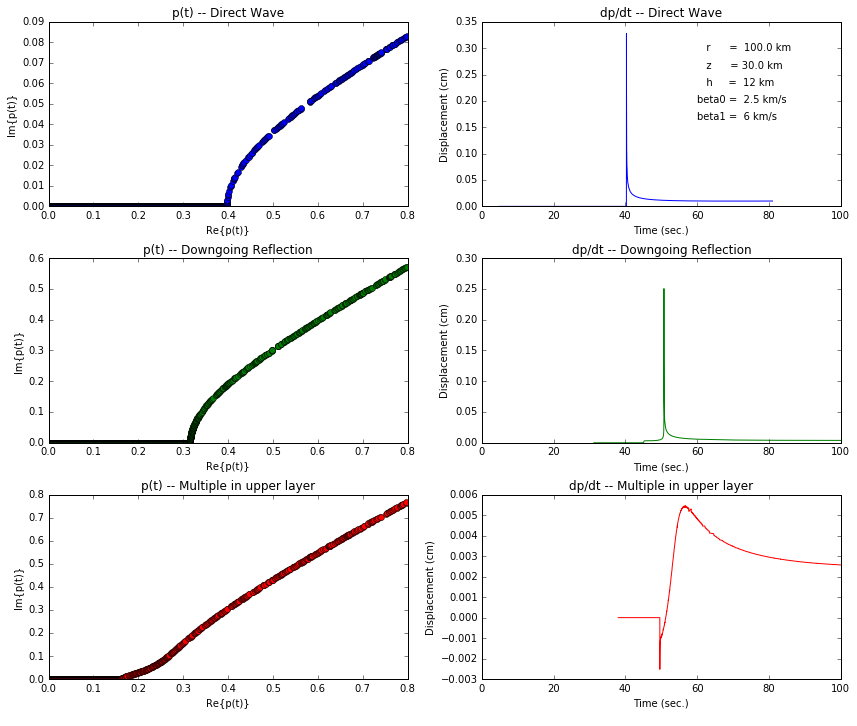

In [416]:
def annotateAxis(ax,r,z,h,beta0,beta1,Ta,x,u):
    ax.annotate('   r      =  %s km' % str(np.round(r,4)), xy=(60,max(u)*.9))
    ax.annotate('   z      = %s km' % str(np.round(z,4)), xy=(60,max(u)*.8))
    ax.annotate('   h     =  %s km' % str(np.round(h,4)), xy=(60,max(u)*.7))
    ax.annotate('beta0 =  %s km/s' % str(np.round(beta0,4)), xy=(60,max(u)*.6))
    ax.annotate('beta1 =  %s km/s' % str(np.round(beta1,4)), xy=(60,max(u)*.5))
    #ax.annotate('arrival time = %s s' % str(np.round(Ta,4)),xy=(55,max(u)*.4))
    return ax

# S0
plt.figure()
fig,ax=plt.subplots(3,2,figsize=(12,10))
ax[0,0].plot(np.real(pp_S0),np.imag(pp_S0),'bo')
ax[0,0].set_title('p(t) -- Direct Wave')
ax[0,1].plot(xi_S0[:-1],u_S0,'b-')
ax[0,1]=annotateAxis(ax[0,1],r,z,h,beta0,beta1,Ta_S0,xi_S0,u_S0)
ax[0,1].set_title('dp/dt -- Direct Wave')
ax[0,1].set_xlim([0,100])
ax[0,0].set_ylabel('Im{p(t)}')
ax[0,0].set_xlabel('Re{p(t)}')
ax[0,1].set_ylabel('Displacement (cm)')
ax[0,1].set_xlabel('Time (sec.)')

# S0R1
plt.figure()
ax[1,0].plot(np.real(pp_S0R1),np.imag(pp_S0R1),'go')
ax[1,0].set_title('p(t) -- Downgoing Reflection')
ax[1,1].plot(xi_S0R1[:-1],-1*u_S0R1,'g-')
#ax[1,1]=annotateAxis(ax[1,1],r,z,h,beta0,beta1,Ta_S0R1,xi_S0R1,u_S0/1.5)
ax[1,1].set_title('dp/dt -- Downgoing Reflection')
ax[1,1].set_xlim([0,100])
ax[1,0].set_ylabel('Im{p(t)}')
ax[1,0].set_xlabel('Re{p(t)}')
ax[1,1].set_ylabel('Displacement (cm)')
ax[1,1].set_xlabel('Time (sec.)')

# # S1T1
# plt.figure()
# ax[2,0].plot(np.real(pp_S1T1),np.imag(pp_S1T1),'ro')
# ax[2,0].set_title('p(t) -- Upgoing Transmission')
# ax[2,1].plot(xi_S1T1[:-1],-1*u_S1T1,'r-')
# ax[2,1]=annotateAxis(ax[2,1],r,z,h,beta0,beta1,Ta_S1T1,xi_S0,u_S0)
# ax[2,1].set_title('dp/dt -- Upgoing Transmission')
# ax[2,1].set_xlim([0,100])

# S1R0R1
plt.figure()
ax[2,0].plot(np.real(pp_S0R0R1),np.imag(pp_S0R0R1),'ro')
ax[2,0].set_title('p(t) -- Multiple in upper layer')
ax[2,1].plot(xi_S0R0R1[:-1],-1*u_S0R0R1,'r-')
ax[2,1]=annotateAxis(ax[2,1],r,z,h,beta0,beta1,Ta_S0R0R1,xi_S0,u_S0)
ax[2,1].set_title('dp/dt -- Multiple in upper layer')
ax[2,1].set_xlim([0,100])
ax[2,0].set_ylabel('Im{p(t)}')
ax[2,0].set_xlabel('Re{p(t)}')
ax[2,1].set_ylabel('Displacement (cm)')
ax[2,1].set_xlabel('Time (sec.)')

fig.tight_layout()